Proje için gereken modüller ve uzantıları çağrıldı. Pandas, Numpy, Matplotlib, tensorflow, tensorflow/keras ve SkLearn.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

Tensorflow Keras'taki cifar10 adlı görsel veriseti; iki eğitim ve iki doğrulama seti olarak 4'e bölündü. Daha sonra da bu veriseti parçalarının boyutu ve matris mertebesi yazdırıldı.

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


Verisetindeki görsellerde bulunan varlıkların türlerle labels adlı liste oluşturuldu. Bunlar etiket görevi görecek. Daha sonra görseller, etiketleriyle birlikte görselleştirildi.

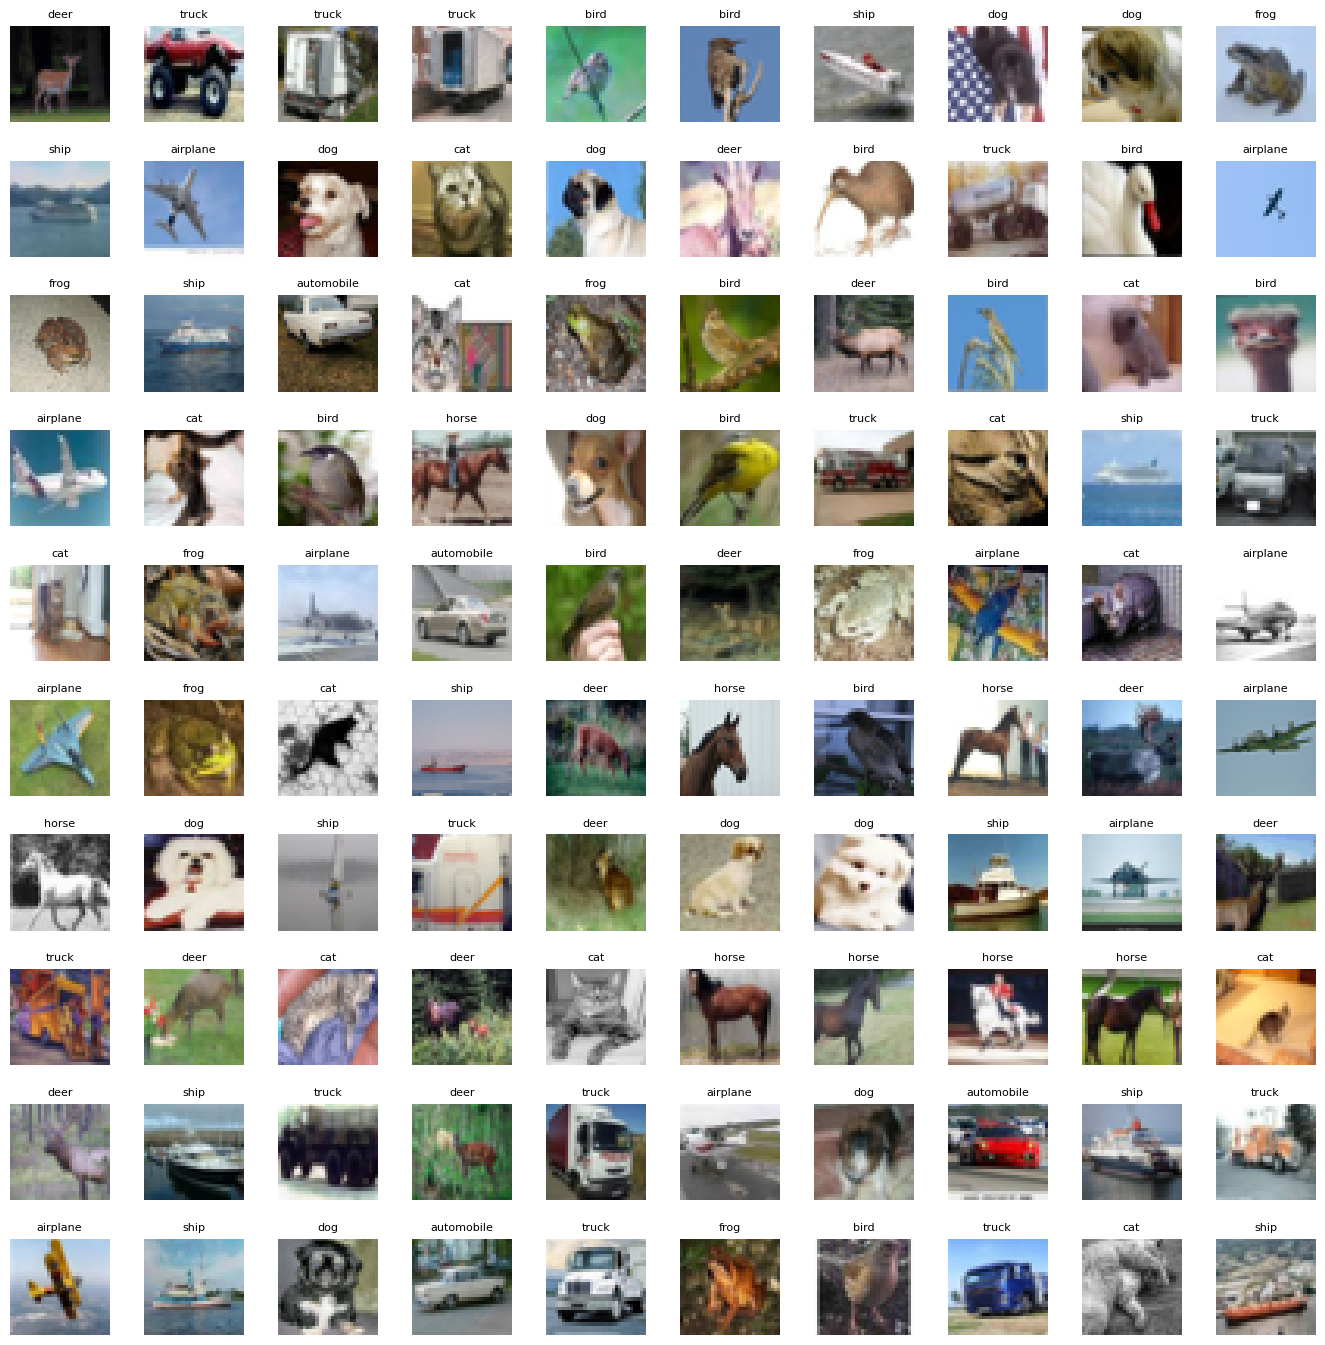

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']


W_grid = 10
L_grid = 10



fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()

n_train = len(X_train)


for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_train)
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Eğitim verisetinde bulunan görsellerdeki varlıkların türleriyle bir sınıf listeli oluşturuldu. Her bir türdeki birbirinden farklı görsellerin miktarları grafikte belirtildi.

Text(0.5, 1.0, 'Class distribution in training set')

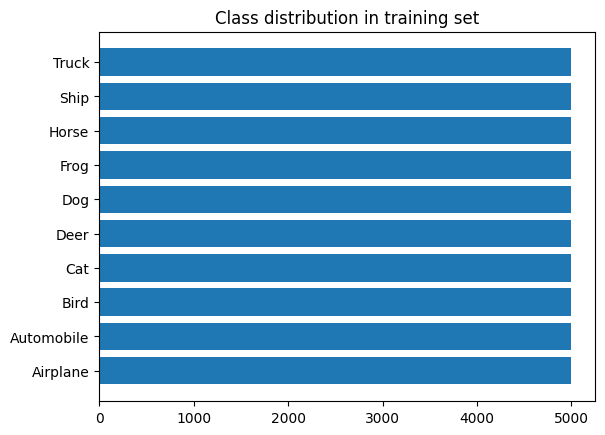

In [ ]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Test verisetinde bulunan varlıkların birbirinden farklı görsellerin miktarları grafikte belirtildi.

Text(0.5, 1.0, 'Class distribution in testing set')

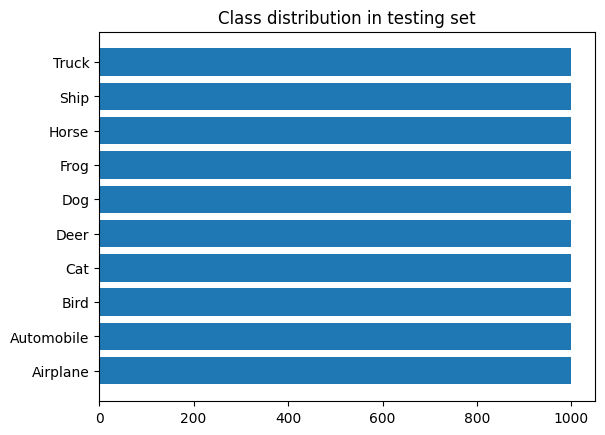

In [ ]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

Eğitim ve doğrulama verisetleri normalize edildi (1,0 aralığına sokuldu). Hedef değişkenler one-hotencoding hale getirildi.

In [ ]:
# Veri Ölçeklendirme
X_train = X_train / 255.0
X_test = X_test / 255.0

# Hedef değişkenleri one-hotencoding hale dönüştürme
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [ ]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

CNN (Convolutional Neural Network - Evreşimli Nöral Ağ) kullanılarak model oluşturuldu, hassaslık ve geri çağrışım skor parametreleri değerlendirme metriğine eklendi. Katmanlar ayarlandı.

In [ ]:
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

Eğitim ve test verisetlerinde oluşan kayıp ve doğruluk kritik olarak azaldığında epoch'u durduracak fonksiyon yazıldı ve model eğitilmeye başlandı.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

r = model.fit(train_generator,
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test),
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/50
1562/1562 [==============================] - 52s 25ms/step - loss: 1.6514 - accuracy: 0.4019 - precision: 0.6233 - recall: 0.1892 - val_loss: 1.3019 - val_accuracy: 0.5304 - val_precision: 0.7135 - val_recall: 0.3836
Epoch 2/50
1562/1562 [==============================] - 40s 26ms/step - loss: 1.2445 - accuracy: 0.5580 - precision: 0.7263 - recall: 0.3886 - val_loss: 1.0114 - val_accuracy: 0.6430 - val_precision: 0.7680 - val_recall: 0.5182
Epoch 3/50
1562/1562 [==============================] - 40s 25ms/step - loss: 1.0592 - accuracy: 0.6331 - precision: 0.7695 - recall: 0.4958 - val_loss: 0.8803 - val_accuracy: 0.6992 - val_precision: 0.8082 - val_recall: 0.5790
Epoch 4/50
1562/1562 [==============================] - 39s 25ms/step - loss: 0.9597 - accuracy: 0.6694 - precision: 0.7892 - recall: 0.5494 - val_loss: 0.8399 - val_accuracy: 0.7183 - val_precision: 0.8040 - val_recall: 0.6381
Epoch 5/50
1562/1562 [==============================] - 38s 24ms/step - loss: 0.8739 - a

Eğitim ve doğrulama veri setlerindeki kayıp, doğruluk, hassaslık ve geri çağrışım skorları 4 ayrı grafikte belirtilmiştir.

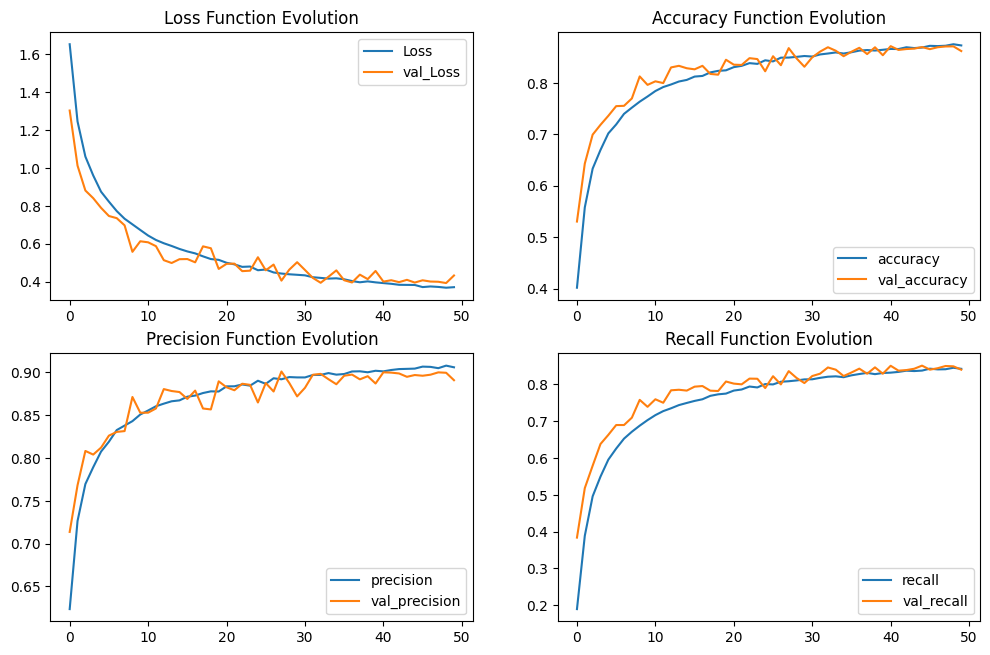

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

Model, doğrulama veriseti parçaları üzerinden değerlendirilerek karmaşıklık matrisiyle doğruluk oranı belirtildi.

313/313 [==============================] - 2s 7ms/step - loss: 0.4322 - accuracy: 0.8616 - precision: 0.8909 - recall: 0.8402
Test Accuracy : 86.16%
313/313 [==============================] - 3s 6ms/step


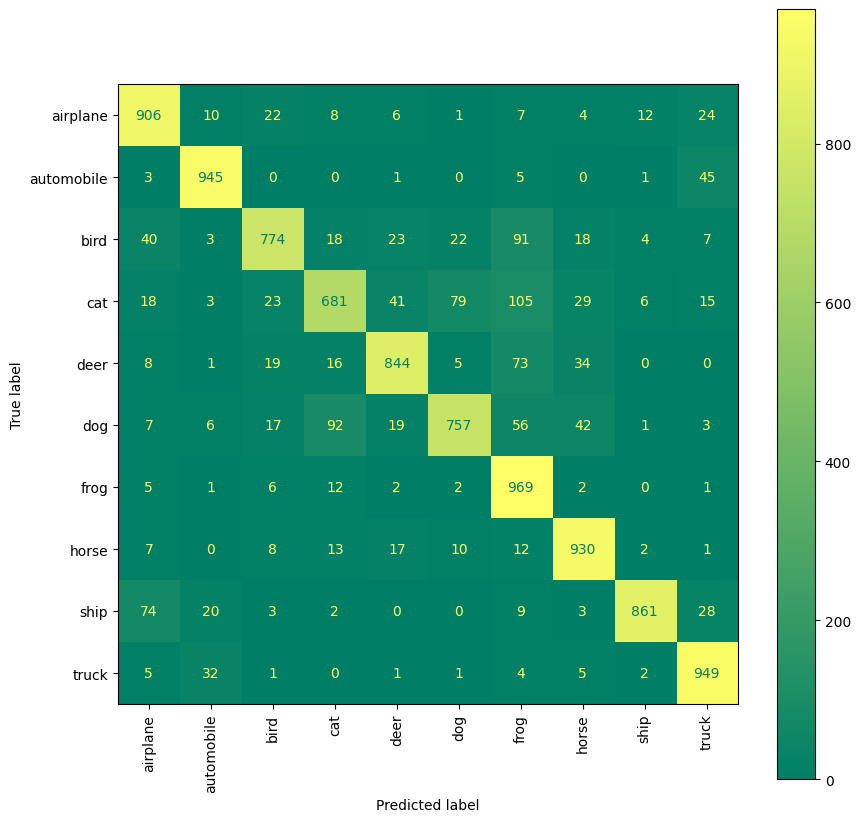

In [ ]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

Modelin görsel sınıflandırma sonuçları belirli parametrelerce altta belirtilmiştir.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1000
           1       0.93      0.94      0.94      1000
           2       0.89      0.77      0.83      1000
           3       0.81      0.68      0.74      1000
           4       0.88      0.84      0.86      1000
           5       0.86      0.76      0.81      1000
           6       0.73      0.97      0.83      1000
           7       0.87      0.93      0.90      1000
           8       0.97      0.86      0.91      1000
           9       0.88      0.95      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



Model, verisetindeki tek bir görselde test edilmiştir.

 Image 100 is [4]
1/1 [==============================] - 1s 838ms/step
The model predict that image 100 is 4


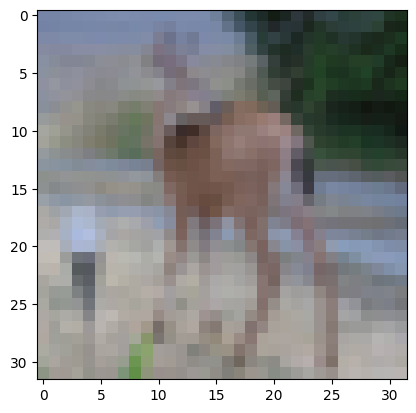

In [ ]:
my_image = X_test[100]
plt.imshow(my_image)

# Resimdeki varlık geyik.
print(f" Image 100 is {y_test[100]}")

# Geyik olarak başarıyla tahmin edildi.
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {pred_100}")

Labels listesi oluşturulup elemanları olarak görsellerin etiketleri eklendi.
Tek bir kare içinde birden fazla görsel test edildi.
Test başarılı sonuçlar verdi.

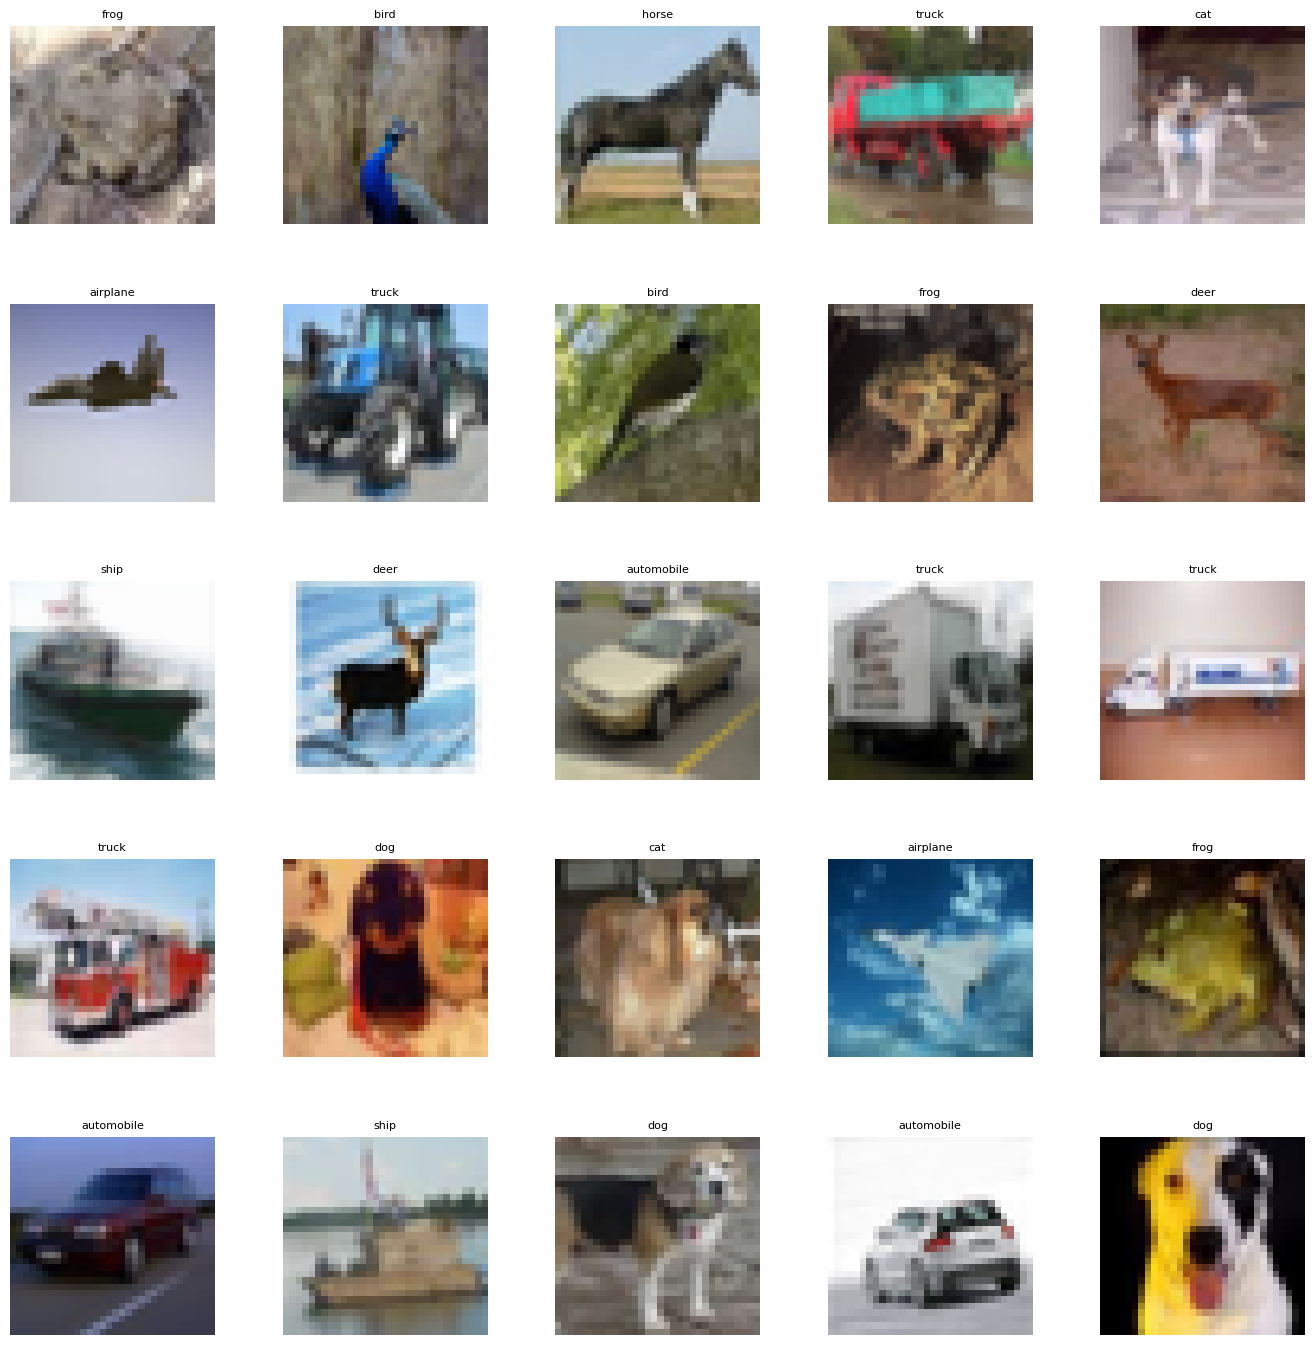

In [ ]:
# Verisetindeki etiketler, labels listesi olarak eklendi.
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Tek kare içinde birden fazla resim test edildi.
# Karenin boyutları altta belirtildi.

W_grid = 5
L_grid = 5

# Eksen nesneleri kullanılarak çeşitli alanlarda belirli görselleri görselleştirebiliriz.

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # 15x15 boyutunda matris 225 elemanlı şekilde düzleştirildi.

n_test = len(X_test) # Eğitim verisetinin boyutu alındı

# 0 ile n_train aralığında rastgele sayı seçildi.
for i in np.arange(0, W_grid * L_grid): # eşit aralıklı değişkenler oluşturuldu.

    # Rastgele bir sayı seçildi
    index = np.random.randint(0, n_test)
    # Seçili indisteki bir görsel okunup ekrana yansıtıldı.
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Görsel sınıflandırma tahminlerinde kesin sonuçların belirtilme şekilleri, doğruluk oranlarını belirtme ve bu tarz durumlar için fonksiyonlar yazıldı.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})",
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

Model kullanılarak 40 adet görsel yanlarında tahminleriyle birlikte belirtildi.

313/313 [==============================] - 1s 4ms/step


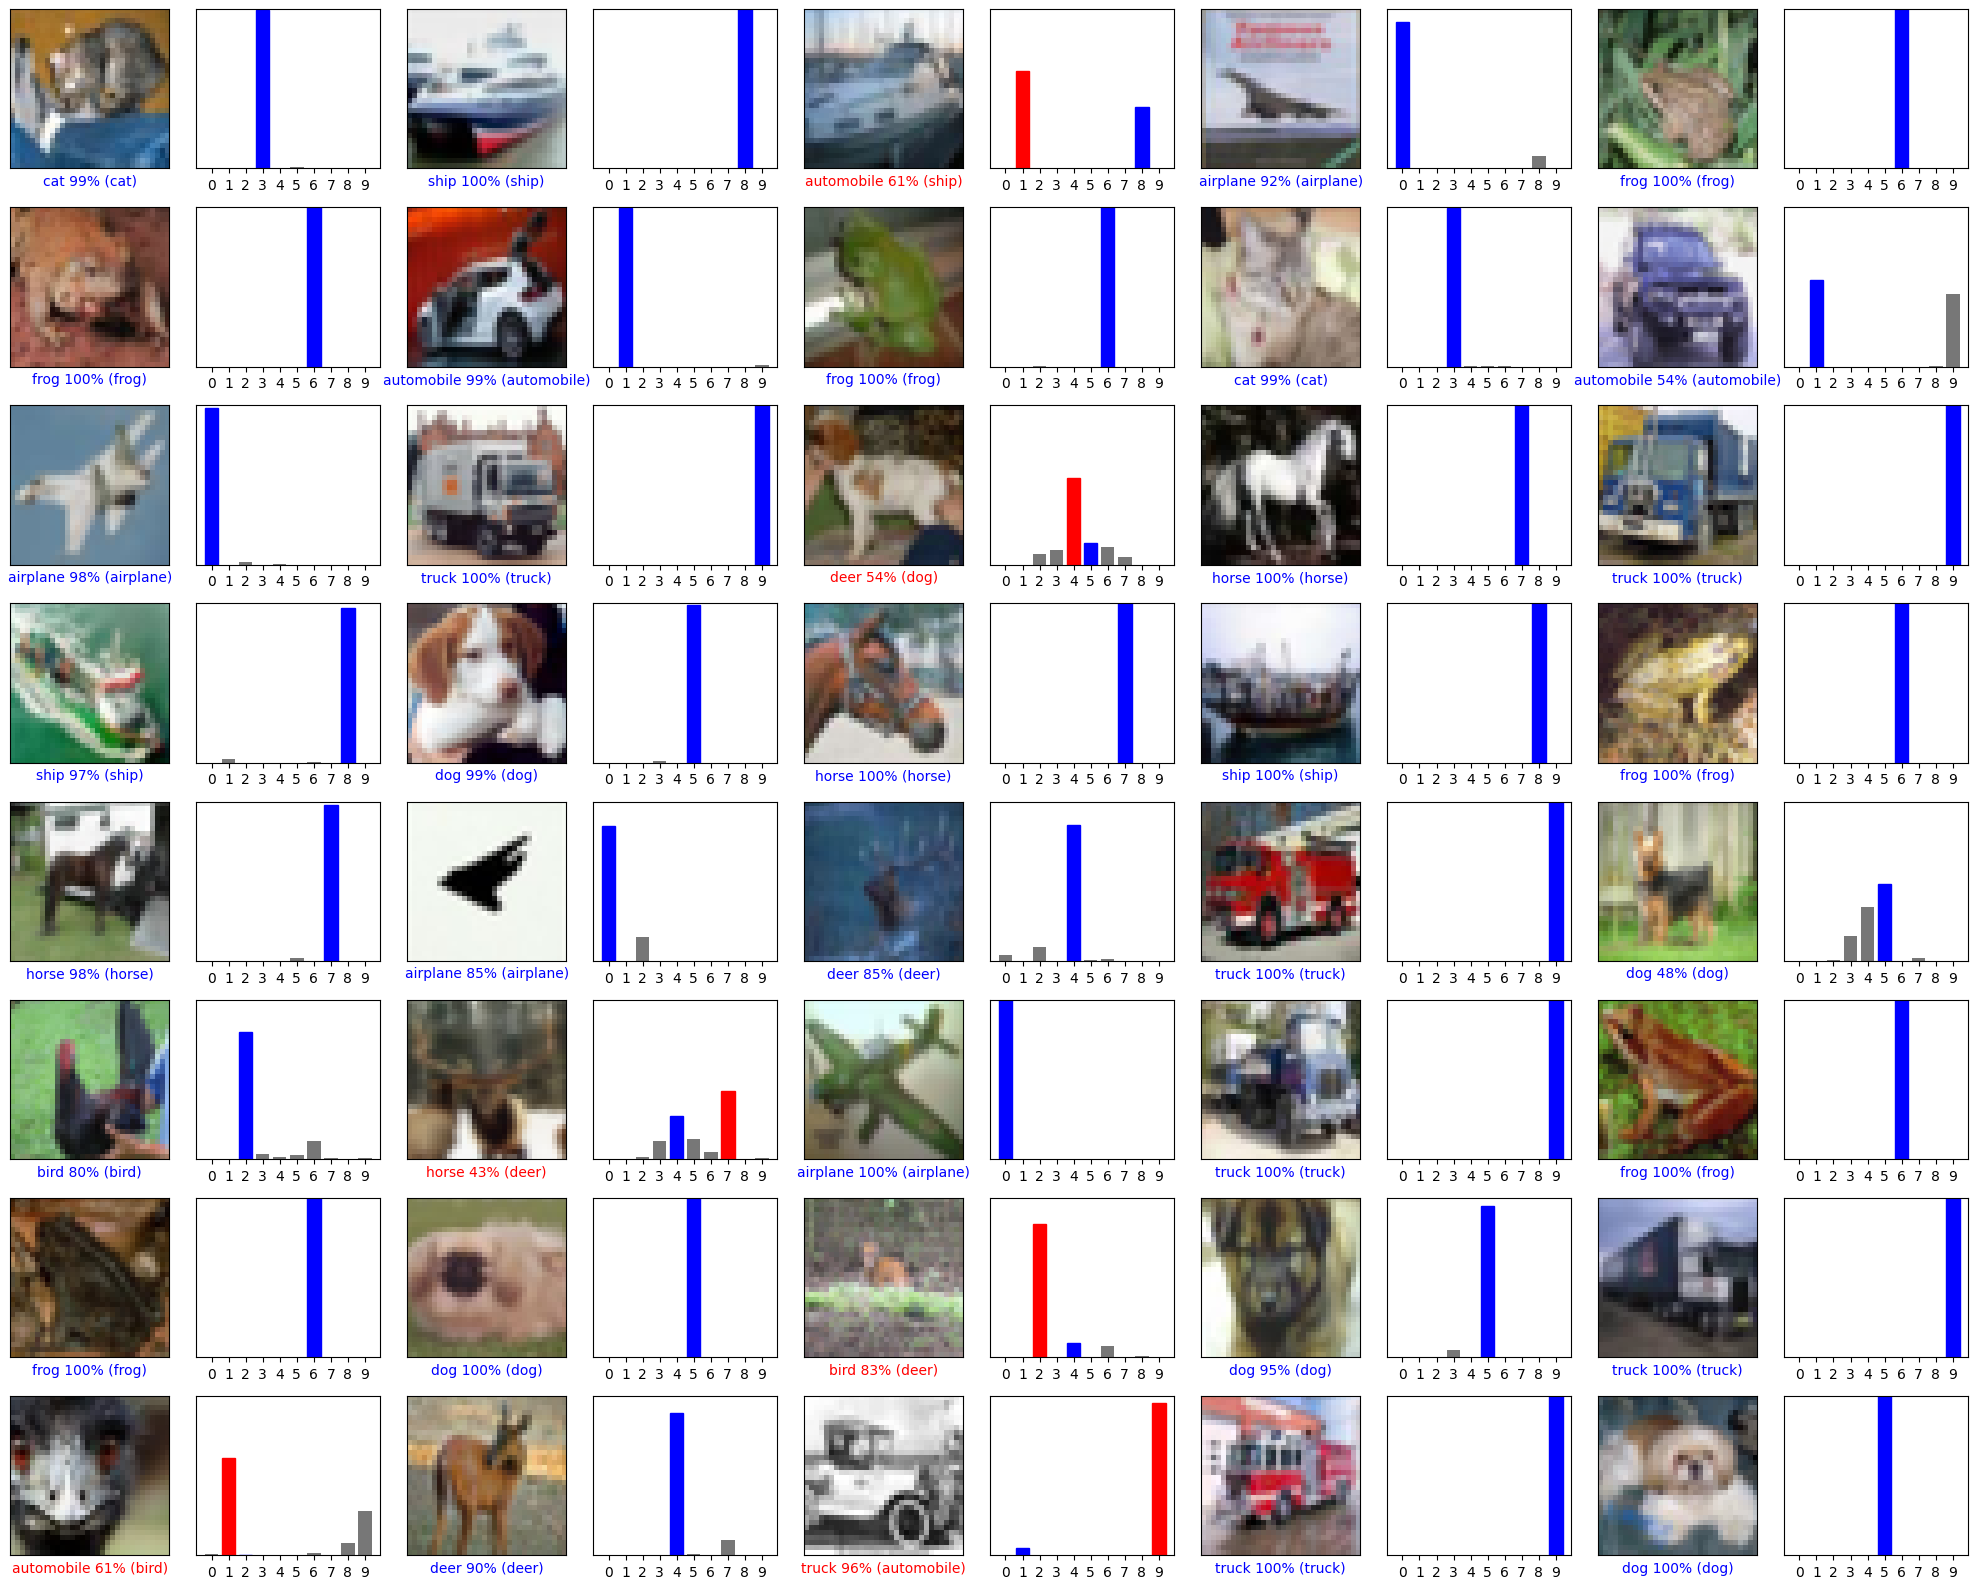

In [ ]:
predictions = model.predict(X_test)

# X_test görüntüleri, tahmin edilen etiketleri ve gerçek etiketleri grafik haline getirildi.
# Color correct predictions in blue and incorrect predictions in red. # Doğru tahminler maviyle, yanlış tahminler kırmızıyla boyandı.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()